<center>

---

# **Random Forest**

---
</center>

 
Un modelo **Random Forest** está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping). 

- Cada árbol se entrena con unos datos ligeramente distintos. 
- En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal.
- La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.


##Ventajas

- Son capaces de seleccionar predictores de forma automática.

- Pueden aplicarse a problemas de regresión y clasificación.

- Los árboles pueden, en teoría, manejar tanto predictores numéricos como categóricos sin tener que crear variables dummy o one-hot-encoding. En la práctica, esto depende de la implementación del algoritmo que tenga cada librería.

- Al tratarse de métodos no paramétricos, no es necesario que se cumpla ningún tipo de distribución específica.

- Por lo general, requieren mucha menos limpieza y pre procesado de los datos en comparación a otros métodos de aprendizaje estadístico (por ejemplo, no requieren estandarización).

- No se ven muy influenciados por outliers.

- Si para alguna observación, el valor de un predictor no está disponible, a pesar de no poder llegar a ningún nodo terminal, se puede conseguir una predicción empleando todas las observaciones que pertenecen al último nodo alcanzado. La precisión de la predicción se verá reducida pero al menos podrá obtenerse.

- Son muy útiles en la exploración de datos, permiten identificar de forma rápida y eficiente las variables (predictores) más importantes.

- Gracias al Out-of-Bag Error puede estimarse su error de validación sin necesidad de recurrir a estrategias computacionalmente costosas como la validación cruzada. Esto no aplica en el caso de series temporales.

- Tienen buena escalabilidad, pueden aplicarse a conjuntos de datos con un elevado número de observaciones

##Desventajas

- Al combinar múltiples árboles, se pierde la interpretabilidad que tienen los modelos basados en un único árbol.

- Cuando tratan con predictores continuos, pierden parte de su información al categorizarlas en el momento de la división de los nodos.

- Tal y como se describe más adelante, la creación de las ramificaciones de los árboles se consigue mediante el algoritmo de recursive binary splitting. Este algoritmo identifica y evalúa las posibles divisiones de cada predictor acorde a una determinada medida (RSS, Gini, entropía…). 

- Los predictores continuos o predictores cualitativos con muchos niveles tienen mayor probabilidad de contener, solo por azar, algún punto de corte óptimo, por lo que suelen verse favorecidos en la creación de los árboles.

- No son capaces de extrapolar fuera del rango de los predictores observado en los datos de entrenamiento.


## Predicción de Random Forest


La predicción de un modelo Random Forest es la media de las predicciones de todos los árboles que lo forman.

Supóngase que se dispone de 10 observaciones, cada una con un valor de variable respuesta  $Y$  y unos predictores  $X$ .


\begin{array}{rrrrrrrrrrr}
\hline \text { id } & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
Y & 10 & 18 & 24 & 8 & 2 & 9 & 16 & 10 & 20 & 14 \\
X & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots
\end{array}

La siguiente imagen muestra cómo sería la predicción del modelo para una nueva observación.



 <img src="https://drive.google.com/uc?id=1ac6vwz2f58Zh7z6SUGUsUnLmMAxyZOK3" />

el valor predicho por cada árbol es la media de la variable respuesta  Y  en el nodo terminal. Acorde a la imagen, las predicciones de cada uno de los tres árboles (de izquierda a derecha) es:


$\hat{y}_{arbol_1} = \frac{24 + 2 + 20}{3} = 15.33333$

$\hat{y}_{arbol_2} = \frac{18 + 24}{2} = 21$

$\hat{y}_{arbol_3} = \frac{18 + 24 + 2 + 20}{4} = 16$

La predicción final del modelo es la media de todas las predicciones individuales:

$\hat{\mu} = \frac{15.33333+21+16}{3} = 17.4$




# Random Forest

In [ ]:
#!pip install scikit-learn==1.1.3

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
sns.set_theme()

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Datos


El set de datos Boston disponible en la librería scikitlearn contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran.

**objetivo:** Ajustar un modelo de regresión que permita predecir el precio medio de una vivienda ```(MEDV)``` en función de las variables disponibles.

Número de instancias(observaciones): 506

Número de atributos: 13 predictivos numéricos/categoriales. 



Información de atributos (variables):
- `CRIM`: índice de criminalidad per cápita por ciudad
- `ZN`: proporción de suelo residencial para lotes de más de 25.000 pies cuadrados
- `INDUS`: proporción de acres comerciales no minoristas por ciudad
- `CHAS`: variable ficticia del río Charles (= 1 si la zona linda con el río; 0 en caso contrario)
- `NOX`: concentración de óxidos nítricos (partes por 10 millones)
- `RM`: número medio de habitaciones por vivienda
- `AGE`: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- `DIS`: distancias ponderadas a cinco centros de empleo de Boston
- `RAD`: índice de accesibilidad a las autopistas radiales
- `TAX`: tasa de impuesto sobre la propiedad por valor total de 10.000 $.
- `PTRATIO`: ratio alumnos-docente por ciudad
- `B`: 1000(Bk - 0,63)^2 donde Bk es la proporción de negros por ciudad
- `LSTAT`: % de estatus inferior de la población
- `MEDV`: Valor medio de las viviendas ocupadas por sus propietarios en miles de dólares
Valores de atributos que faltan: Ninguno


Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learnin

In [ ]:
# Se unen todos los datos (predictores y variable respuesta en un único dataframe)
boston = load_boston(return_X_y=False)
datos = np.column_stack((boston.data, boston.target))
datos = pd.DataFrame(datos,columns = np.append(boston.feature_names, "MEDV"))
datos.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas a

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datos.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='MEDV', ylabel='Count'>

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


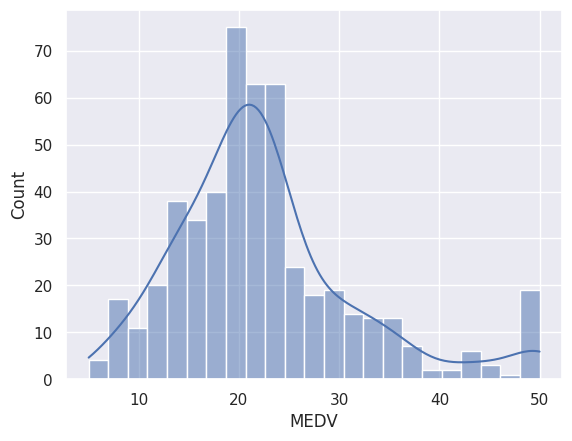

In [ ]:
sns.histplot(datos["MEDV"], kde=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: ylabel='MEDV'>

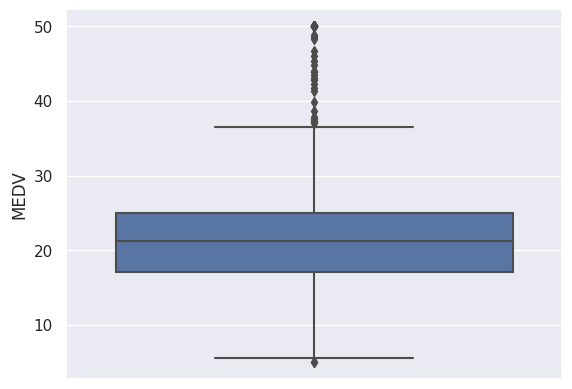

In [ ]:
sns.boxplot(y=datos["MEDV"])

In [ ]:
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Numero de cuartos vs valor medio de la vivienda')

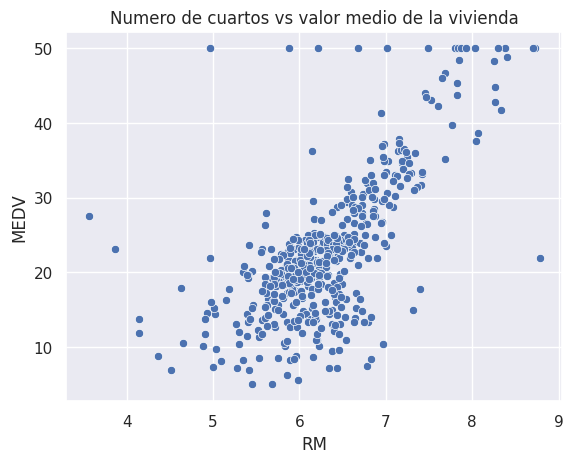

In [ ]:
sns.scatterplot(data=datos, x="RM", y="MEDV")
plt.title("Numero de cuartos vs valor medio de la vivienda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='CRIM', ylabel='MEDV'>

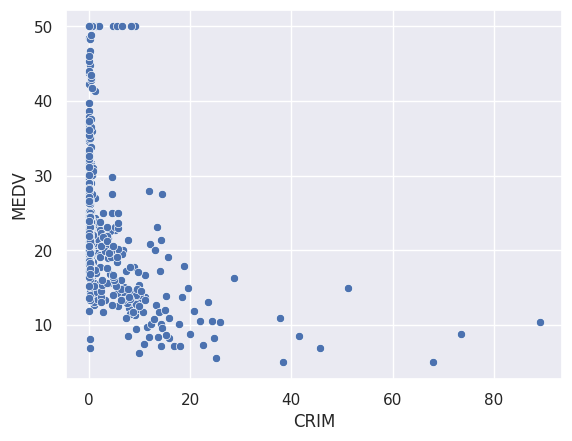

In [ ]:
sns.scatterplot(data=datos, x="CRIM", y="MEDV")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='B', ylabel='MEDV'>

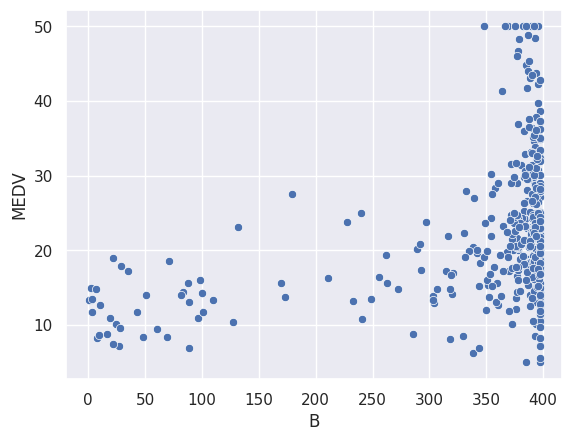

In [ ]:
sns.scatterplot(x=datos["B"], y=datos["MEDV"])

In [ ]:
!pip install sweetviz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sweetviz


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

In [ ]:
reporte=sweetviz.analyze(datos, "MEDV")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



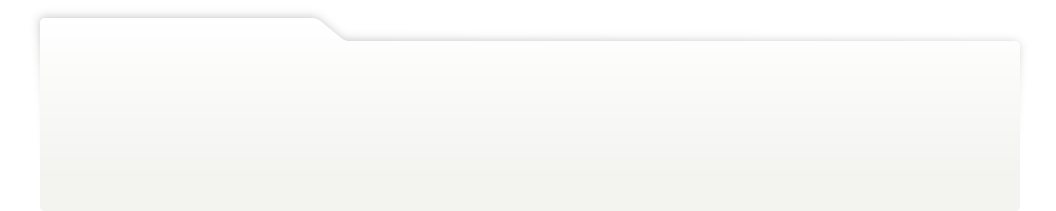
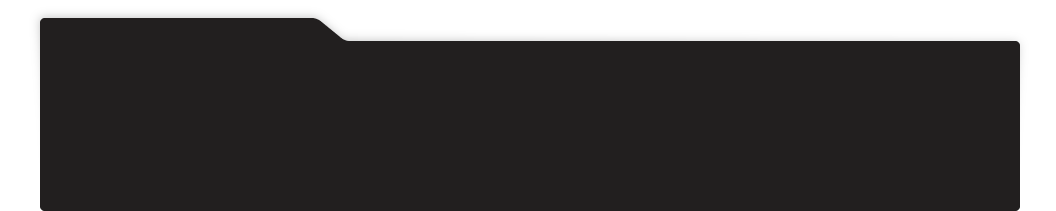
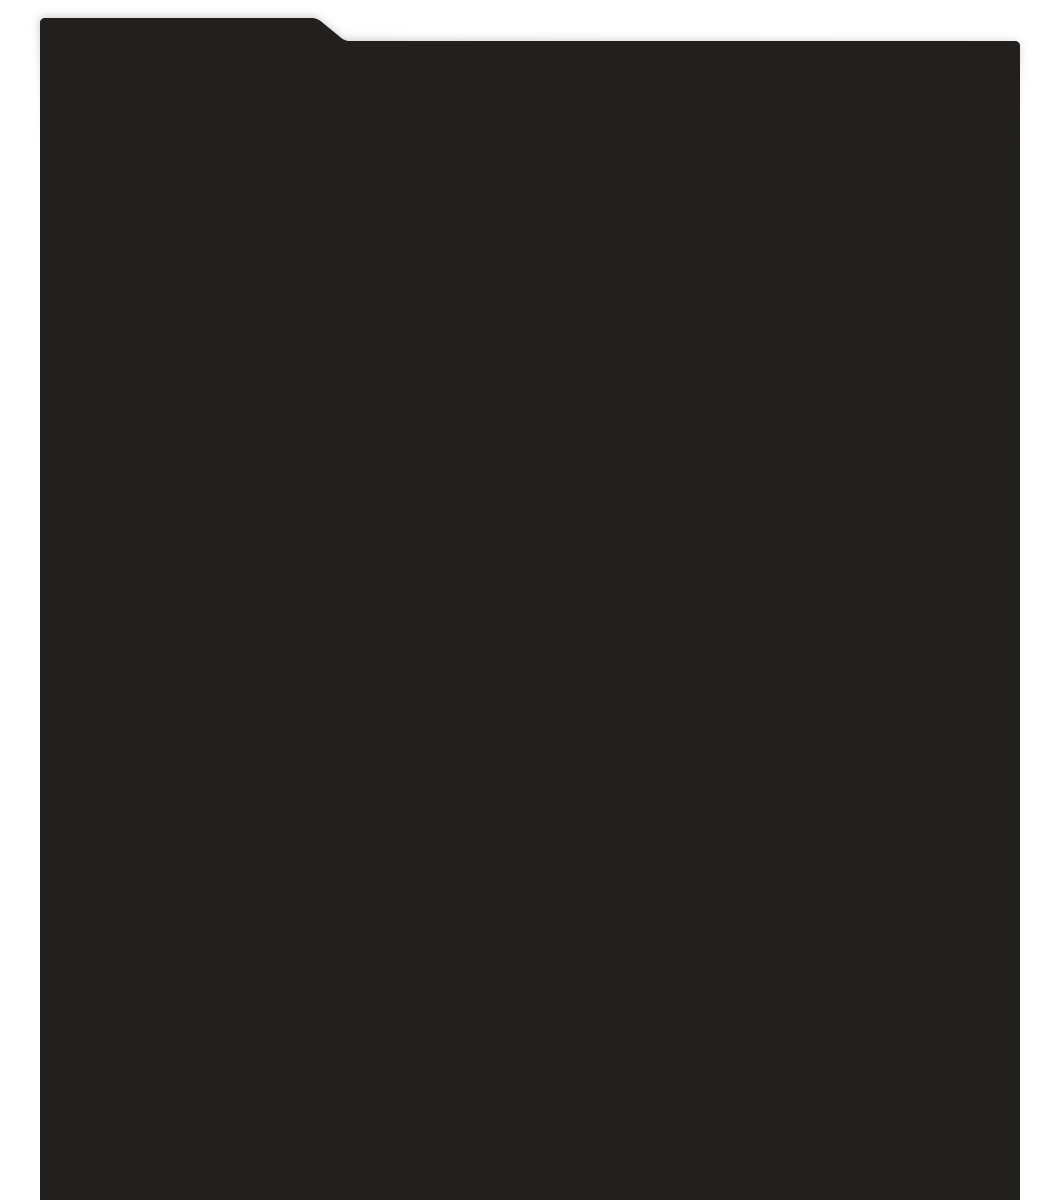
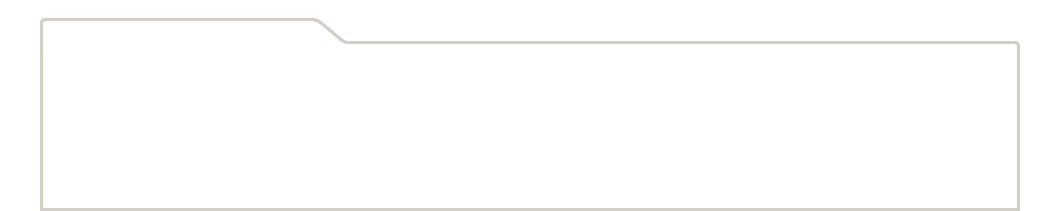
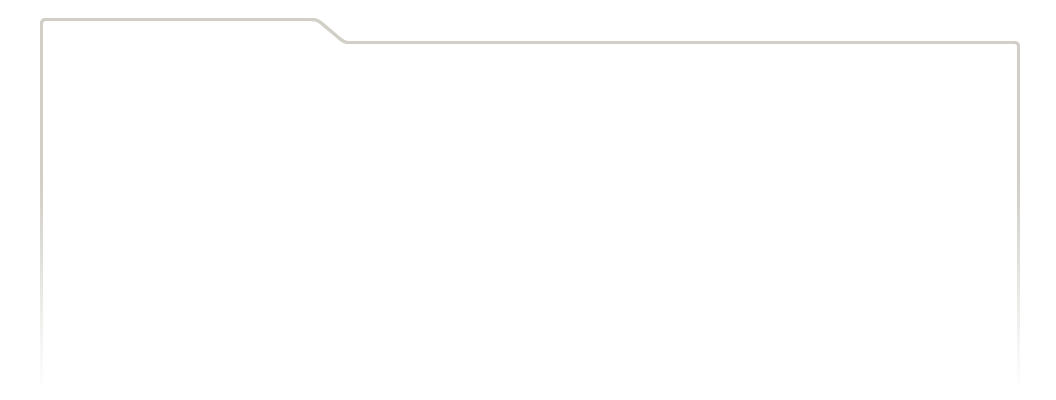
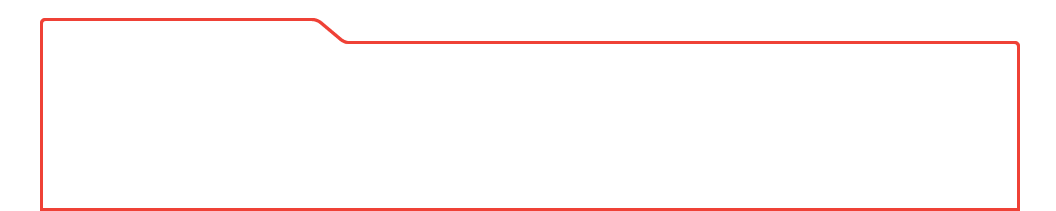
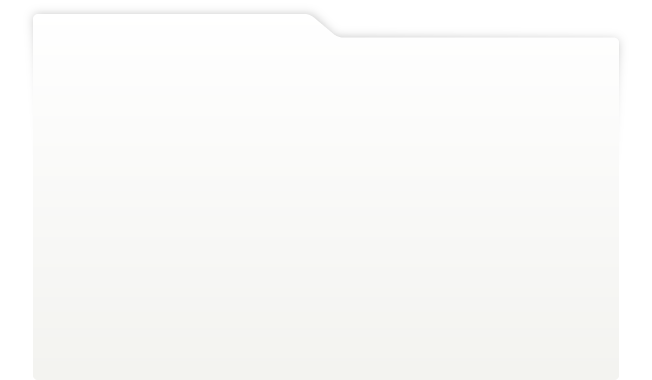
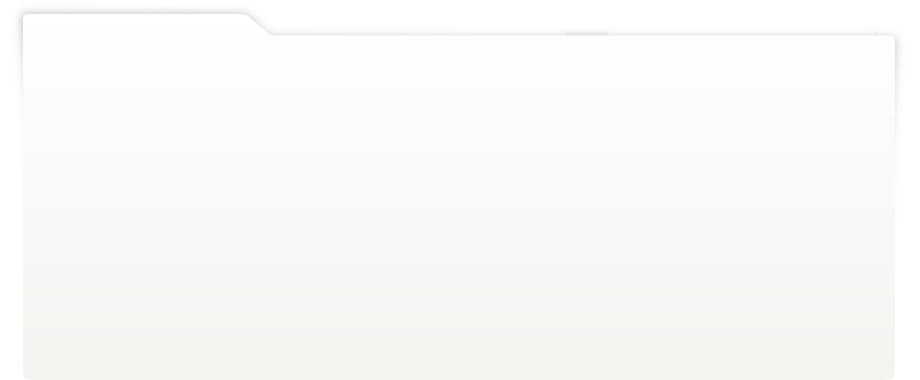
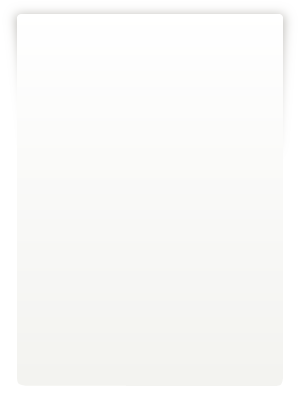
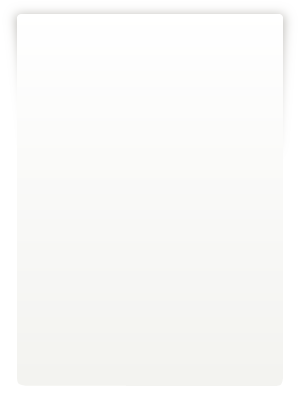
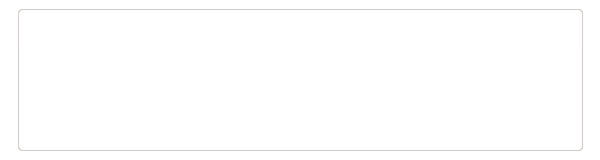
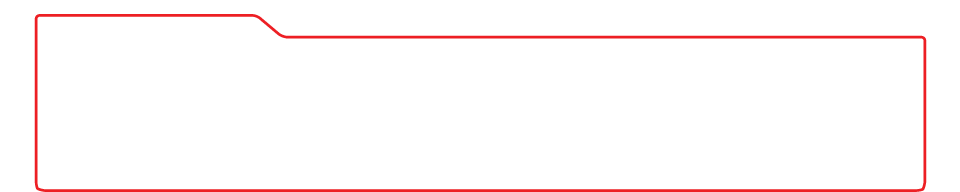
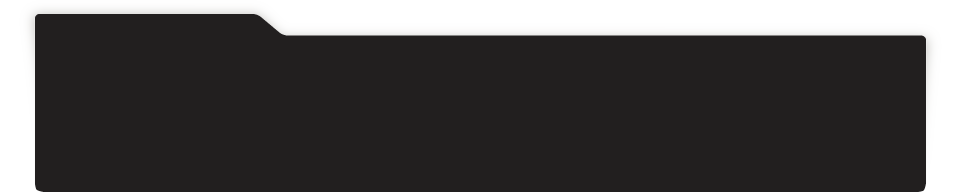
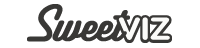
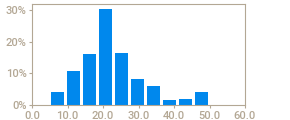
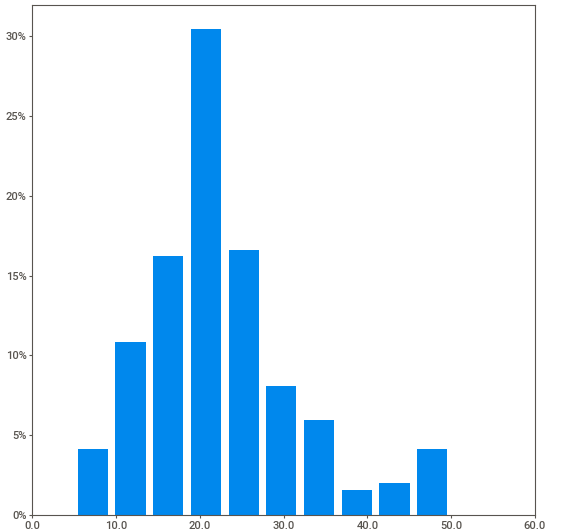
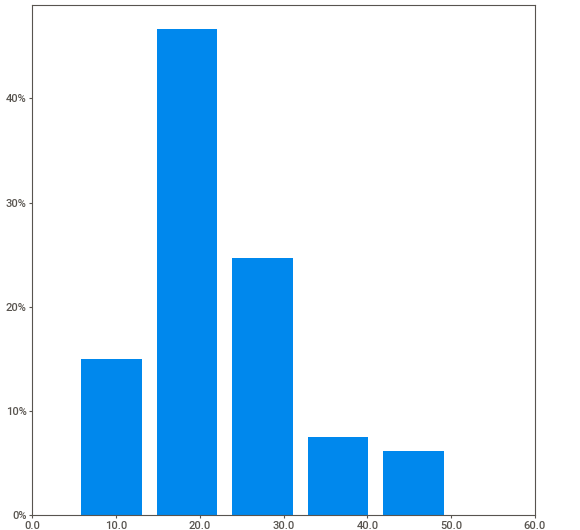
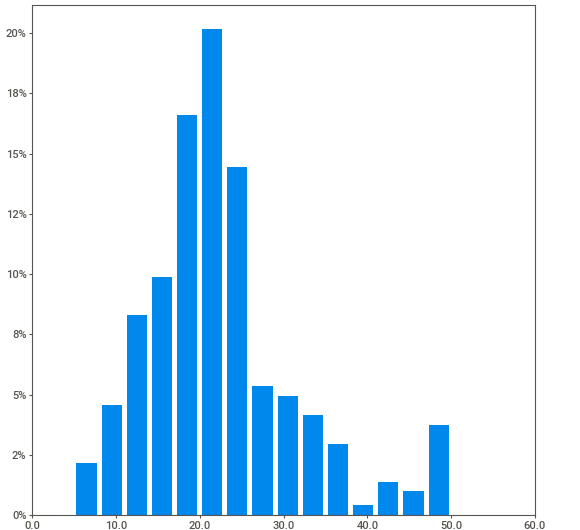
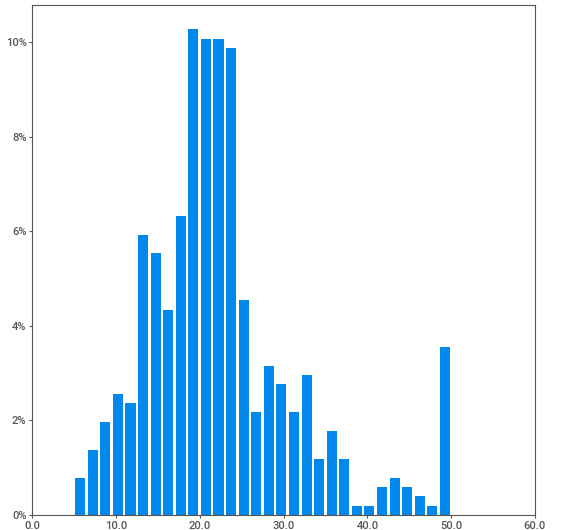
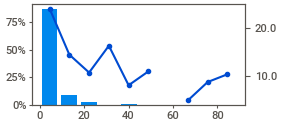
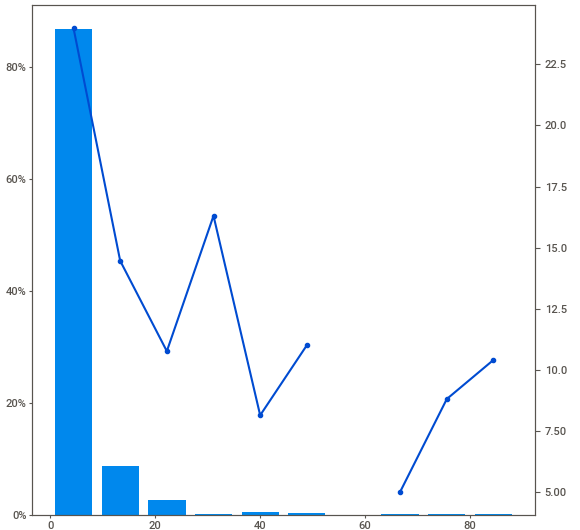
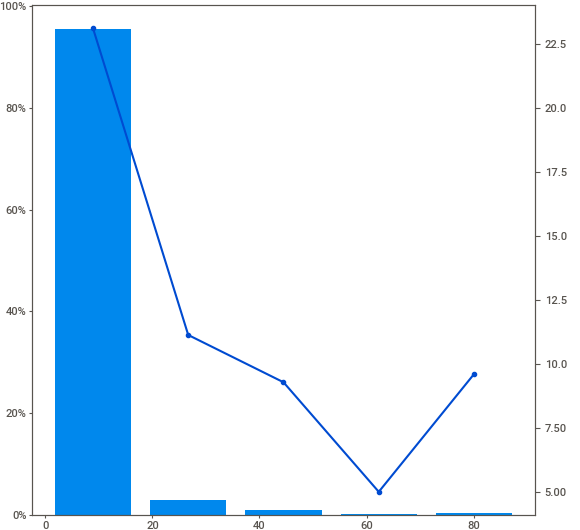
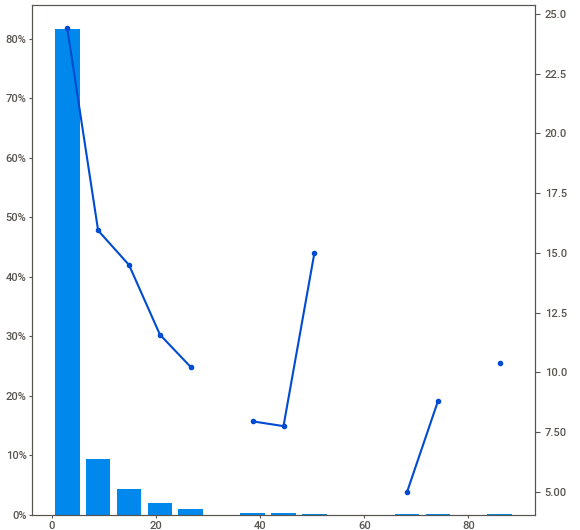
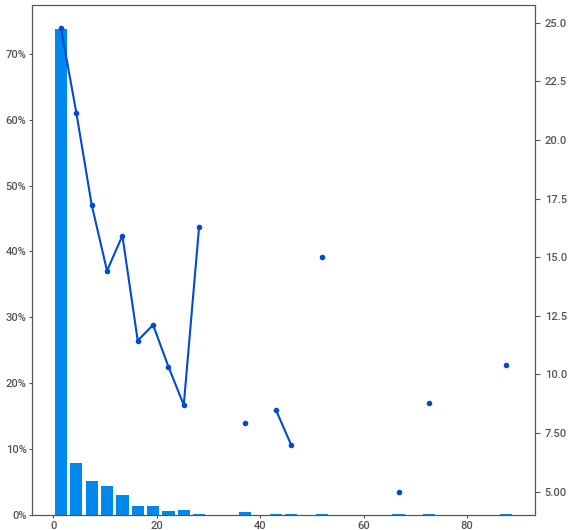
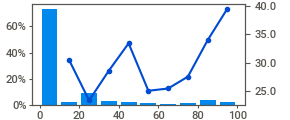
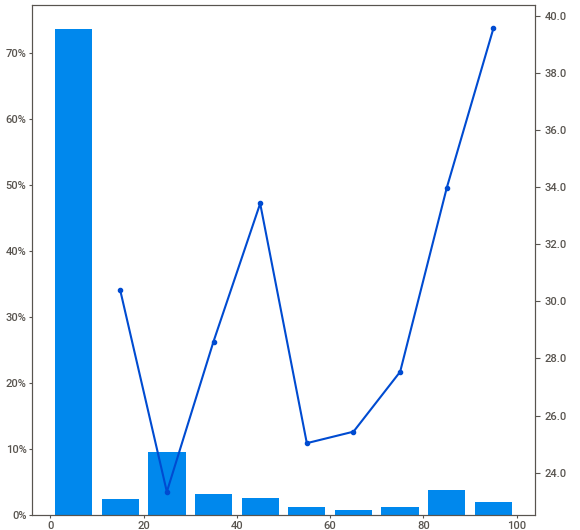
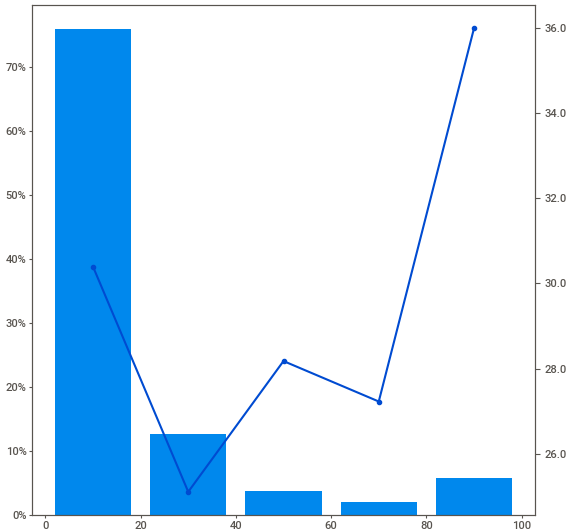
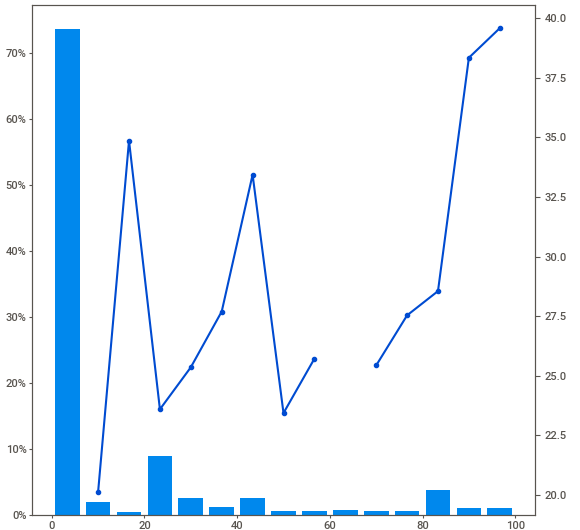
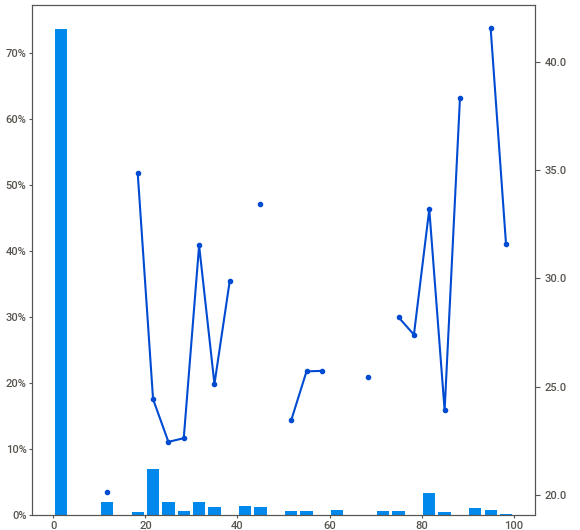
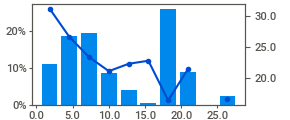
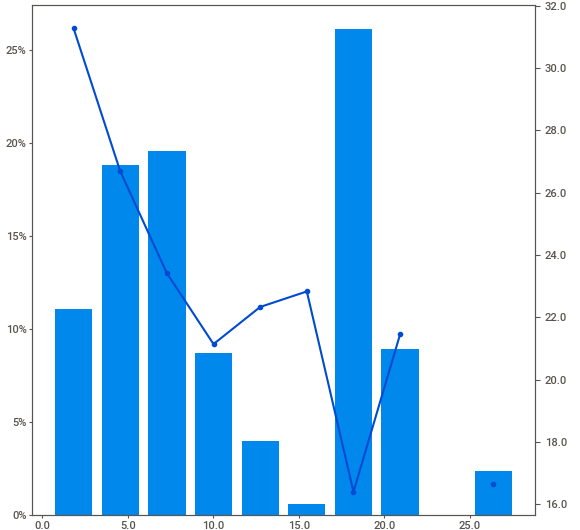
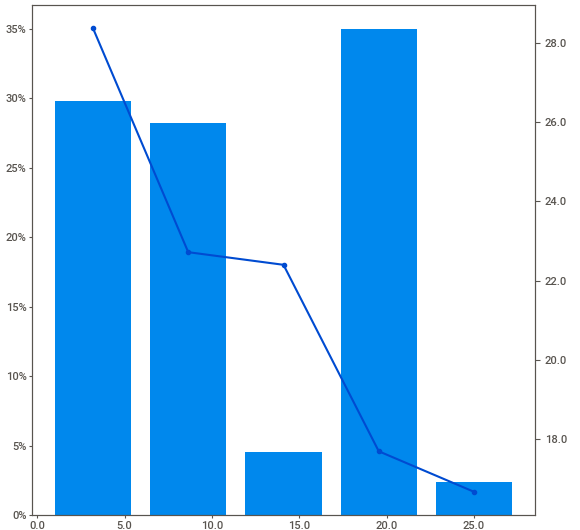
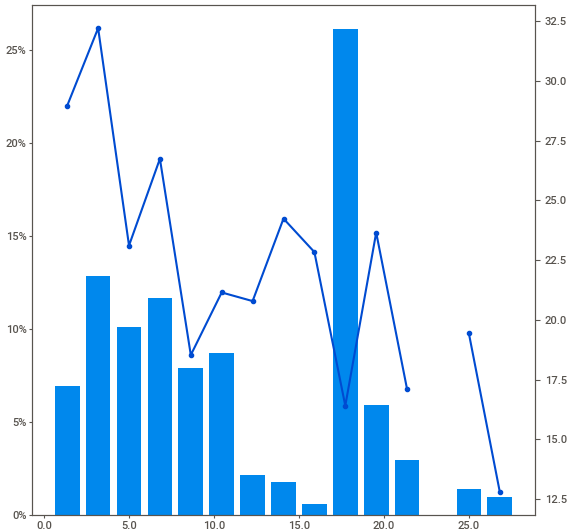
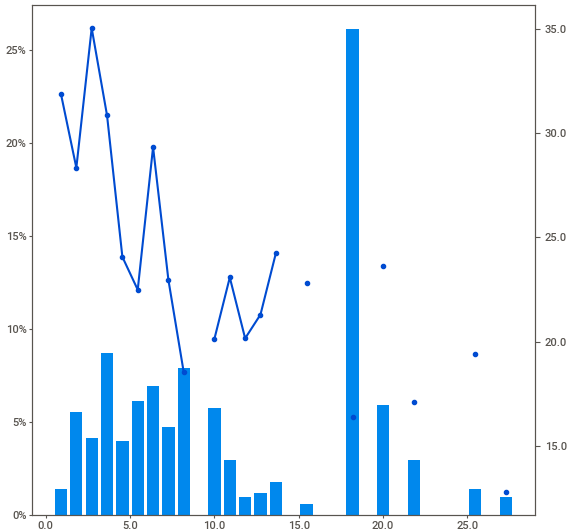
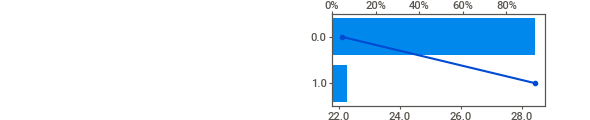
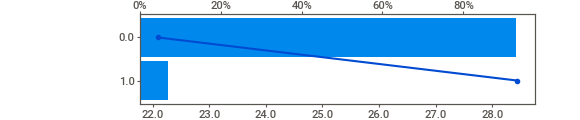
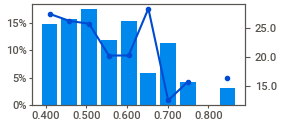
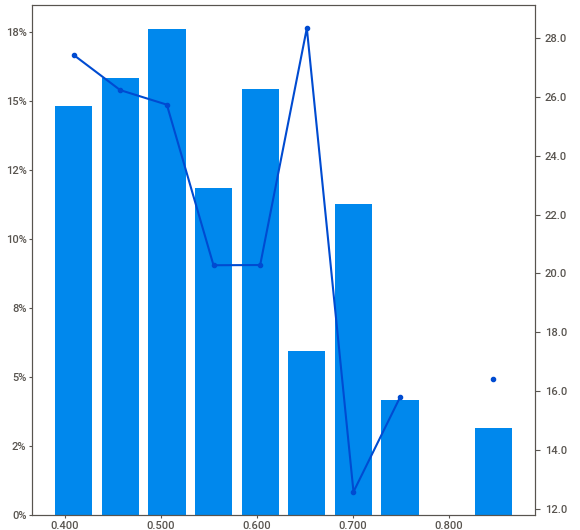
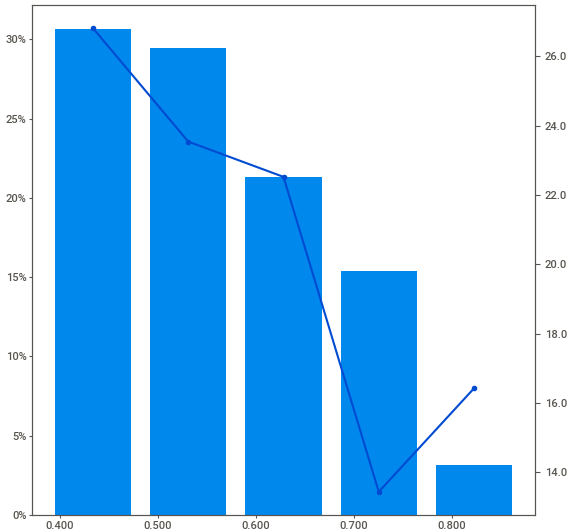
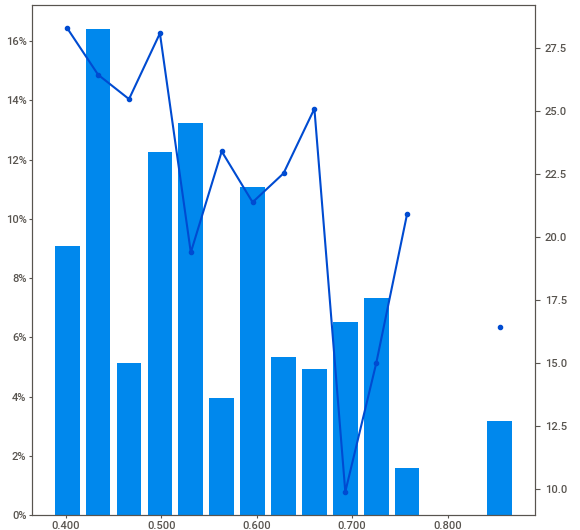
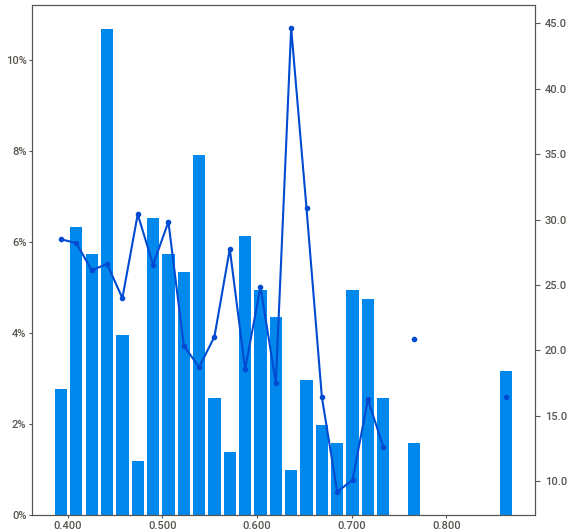
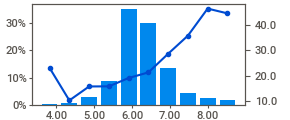
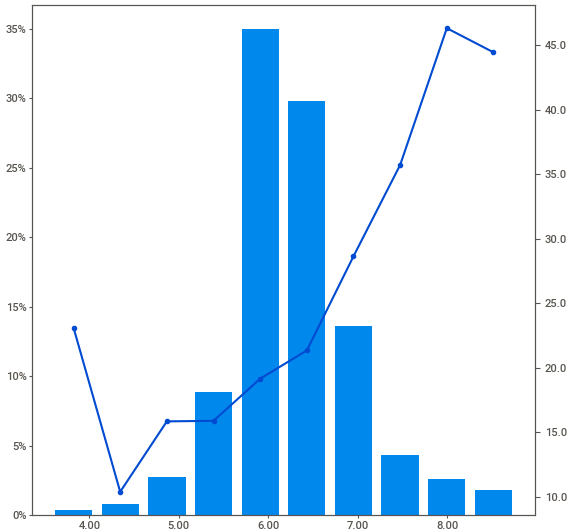
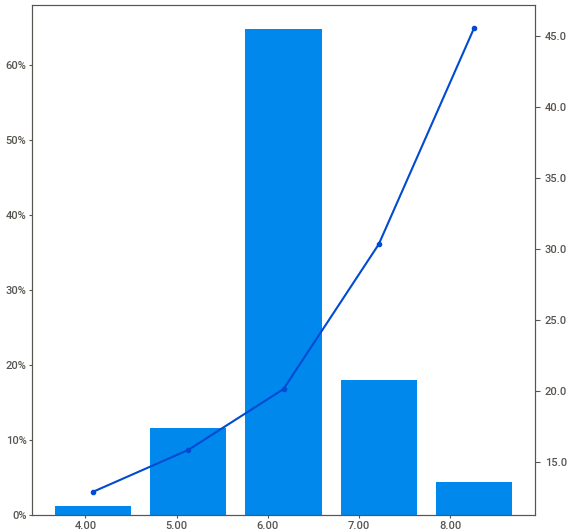
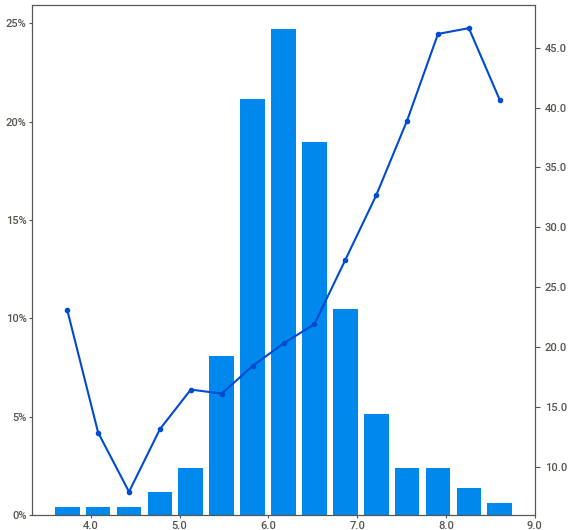
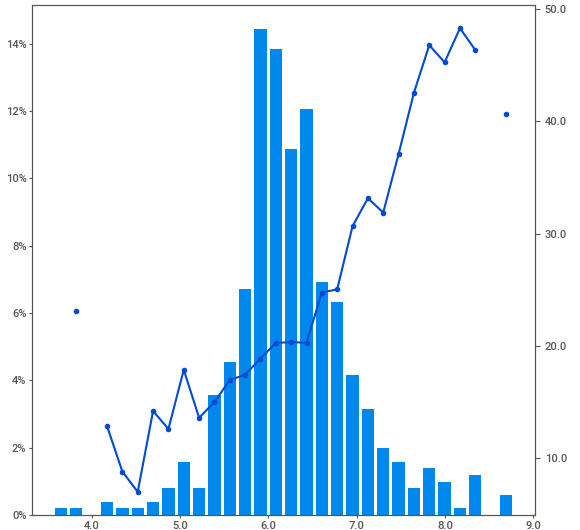
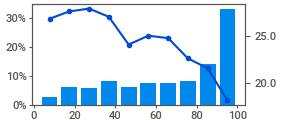
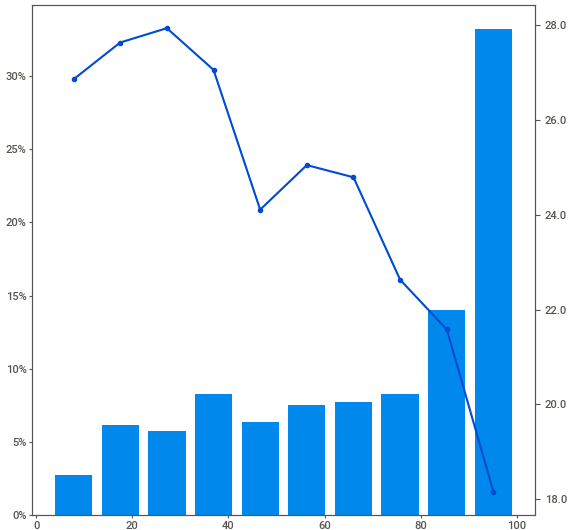
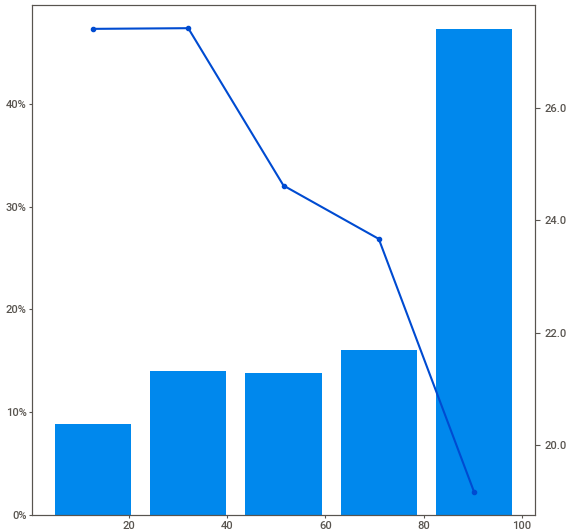
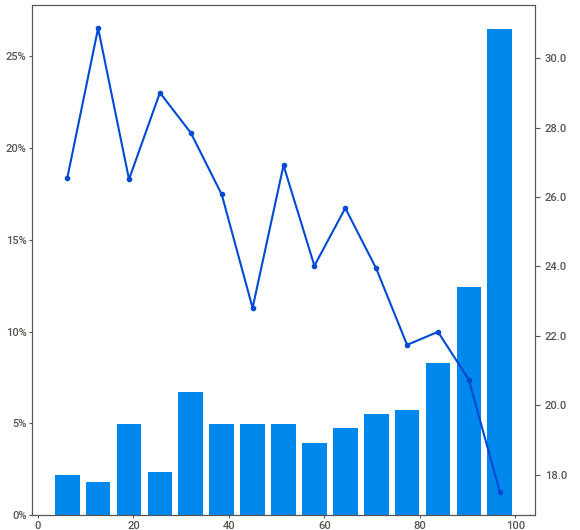
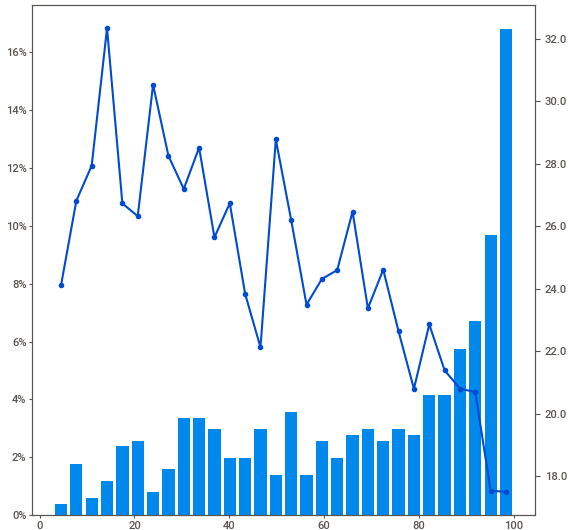
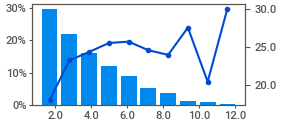
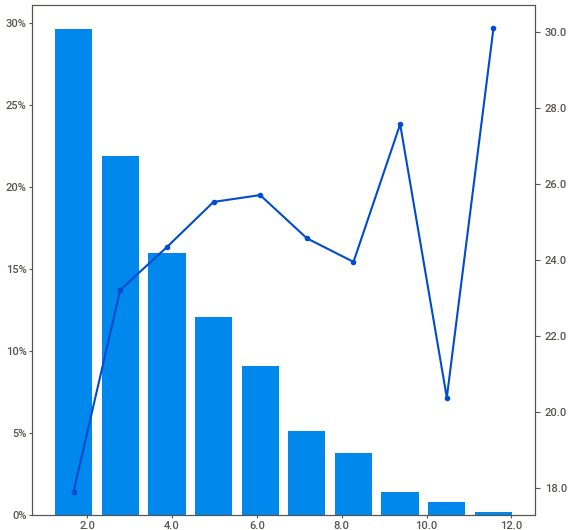
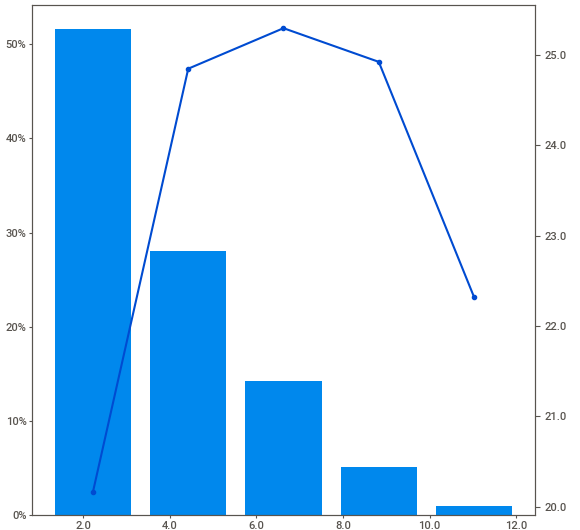
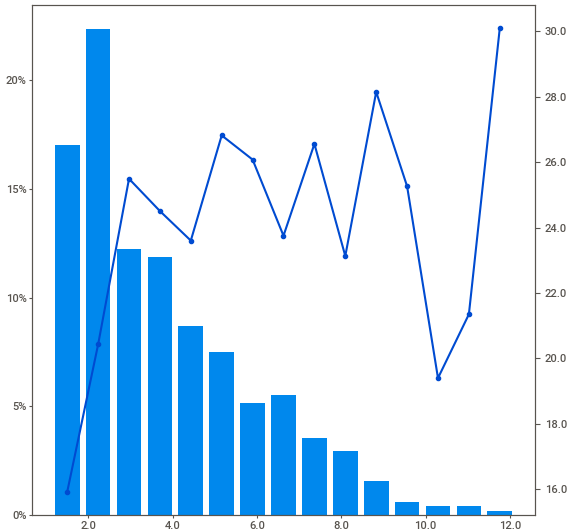
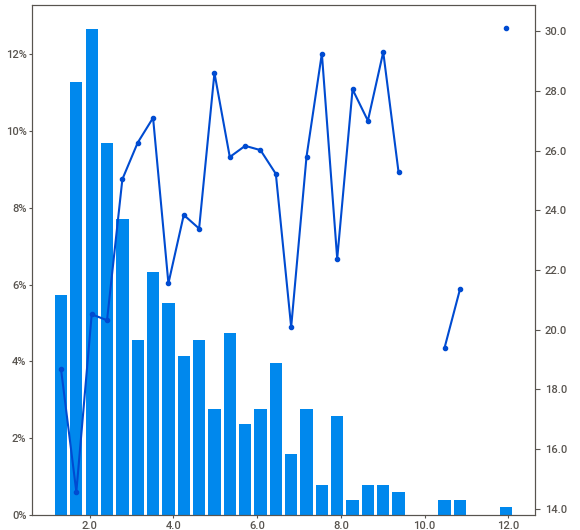
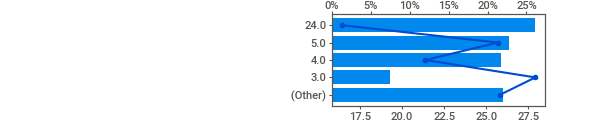
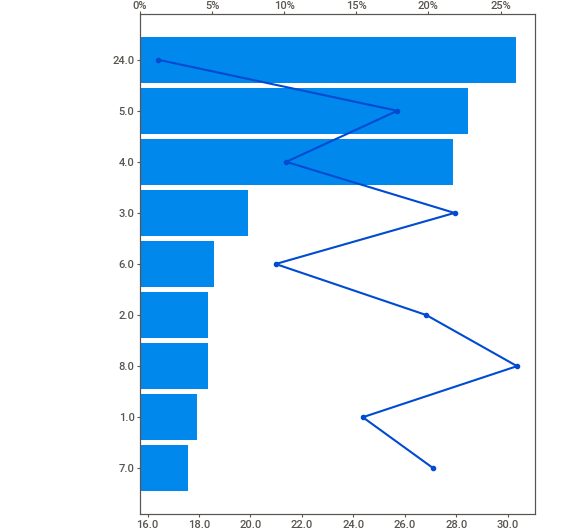
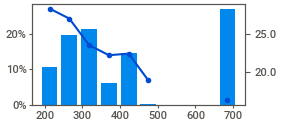
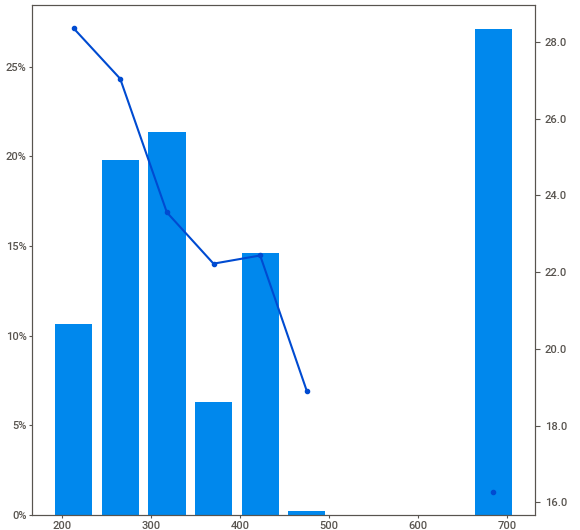
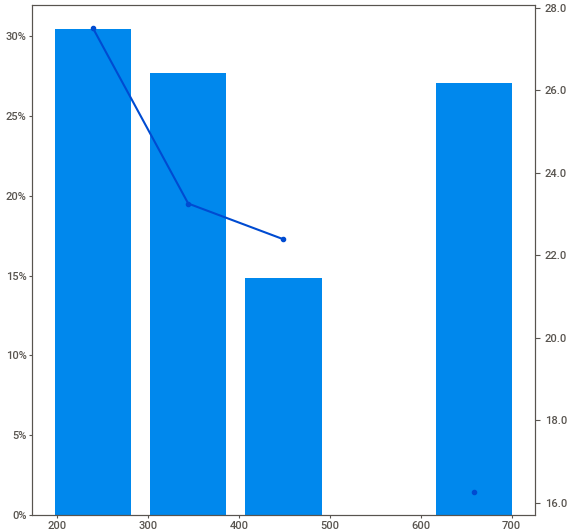
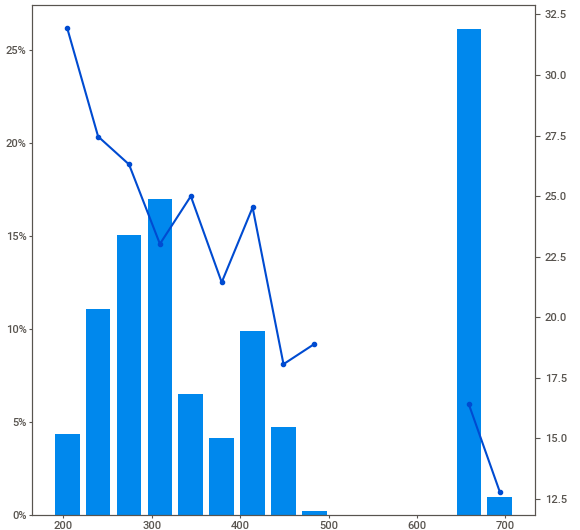
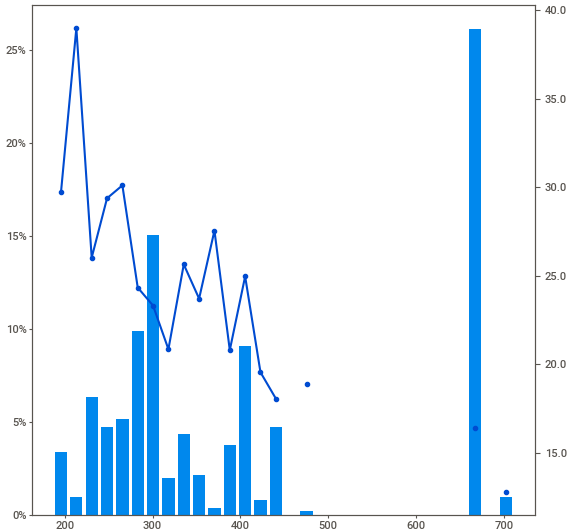
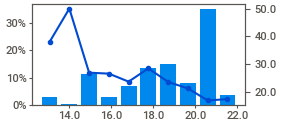
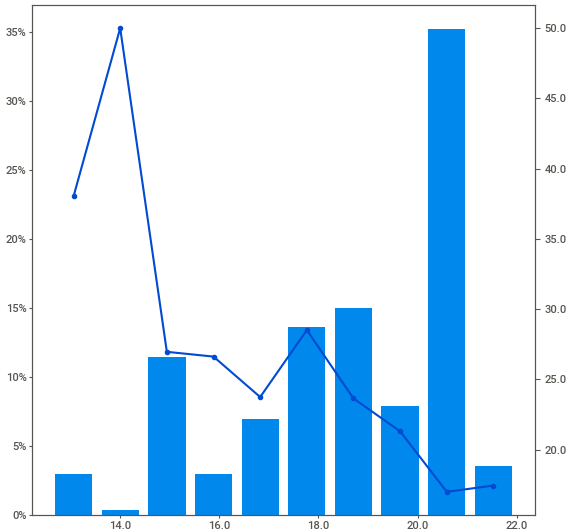
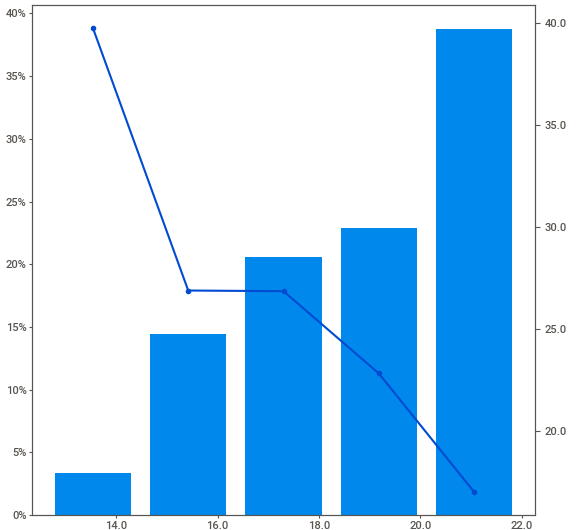
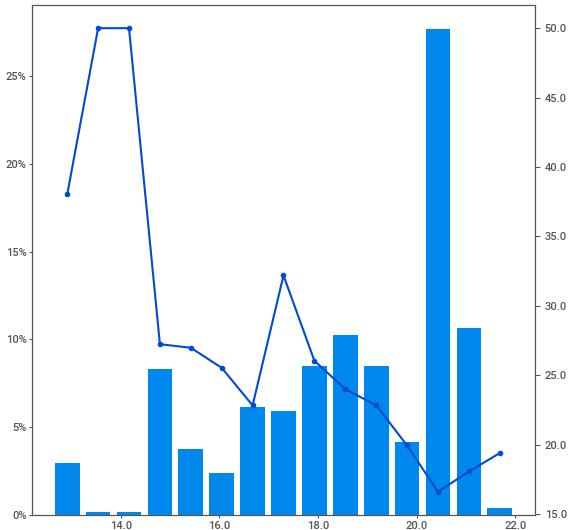
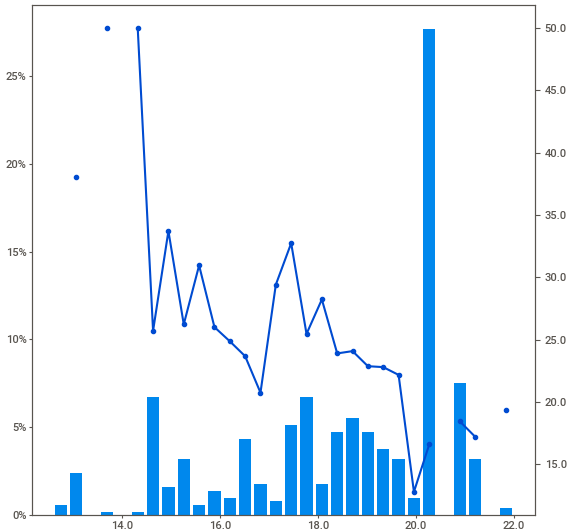
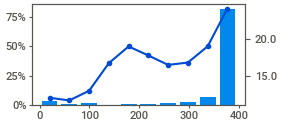
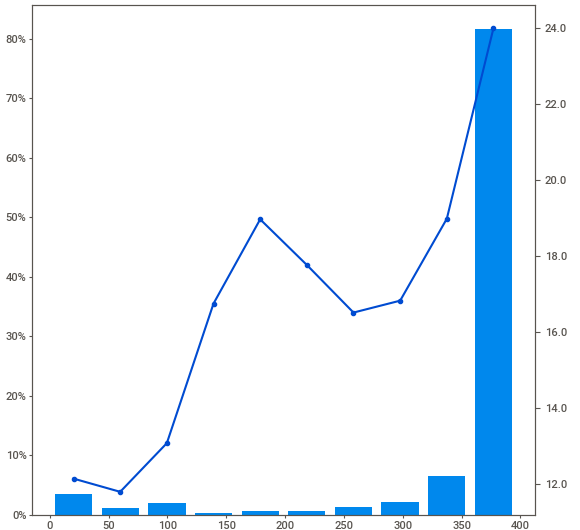
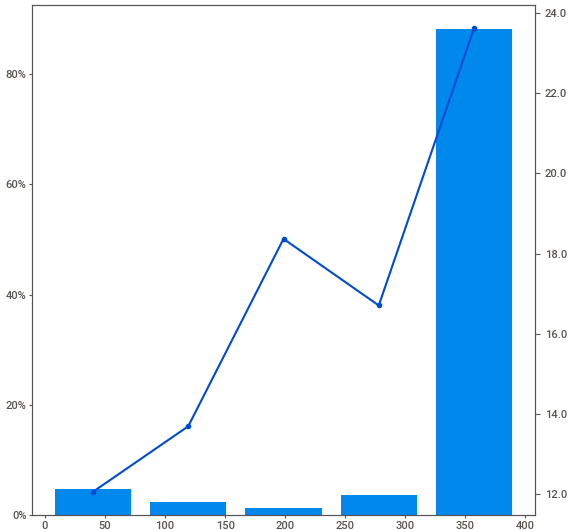
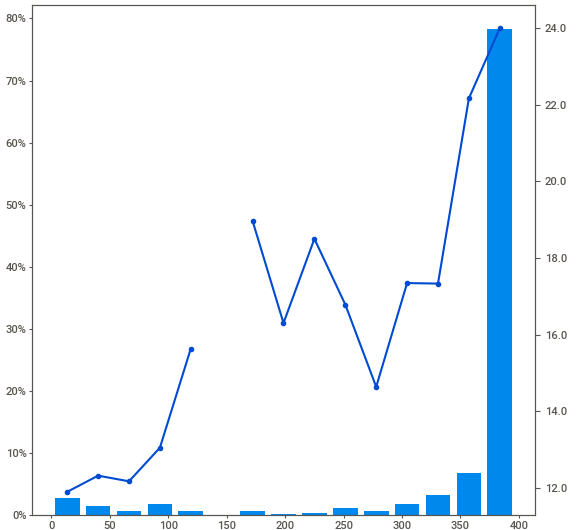
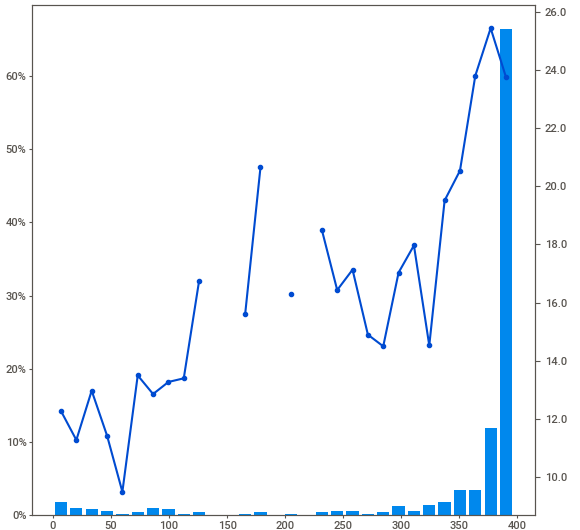
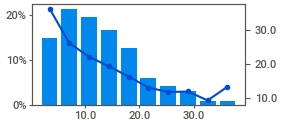
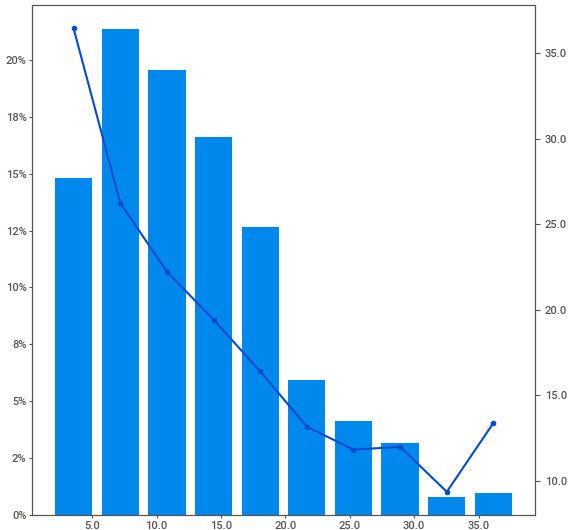
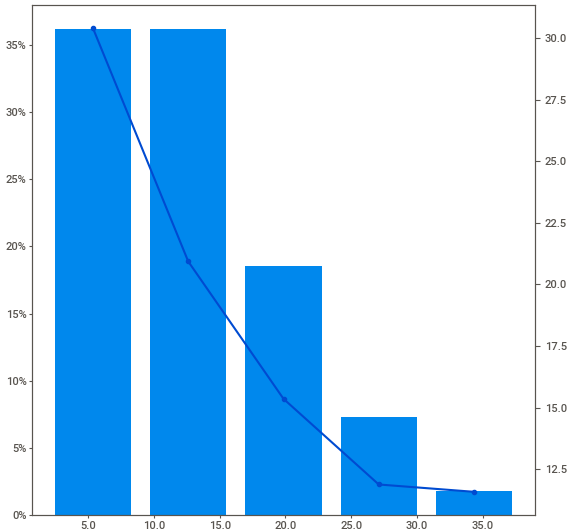
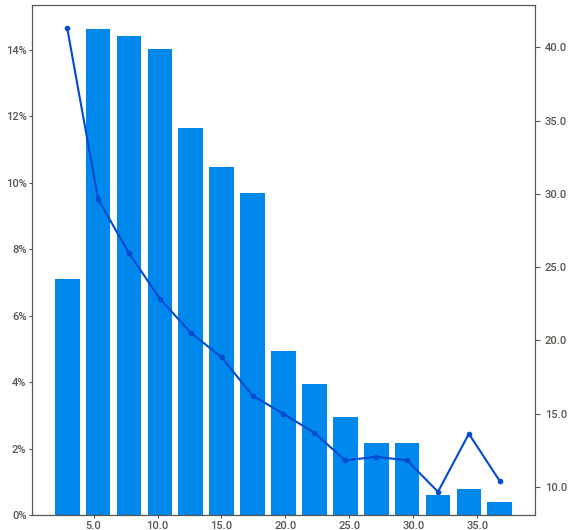
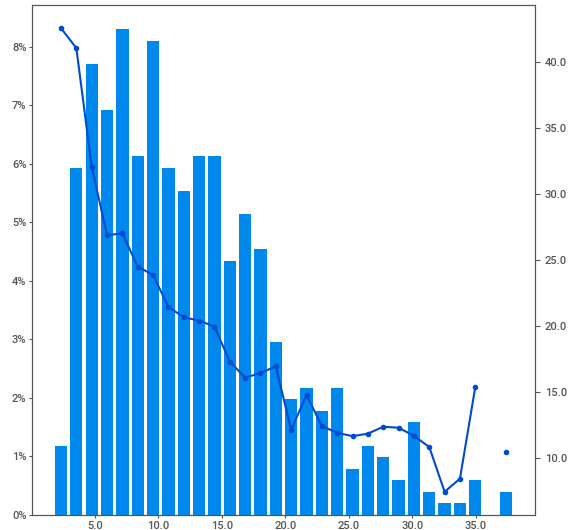
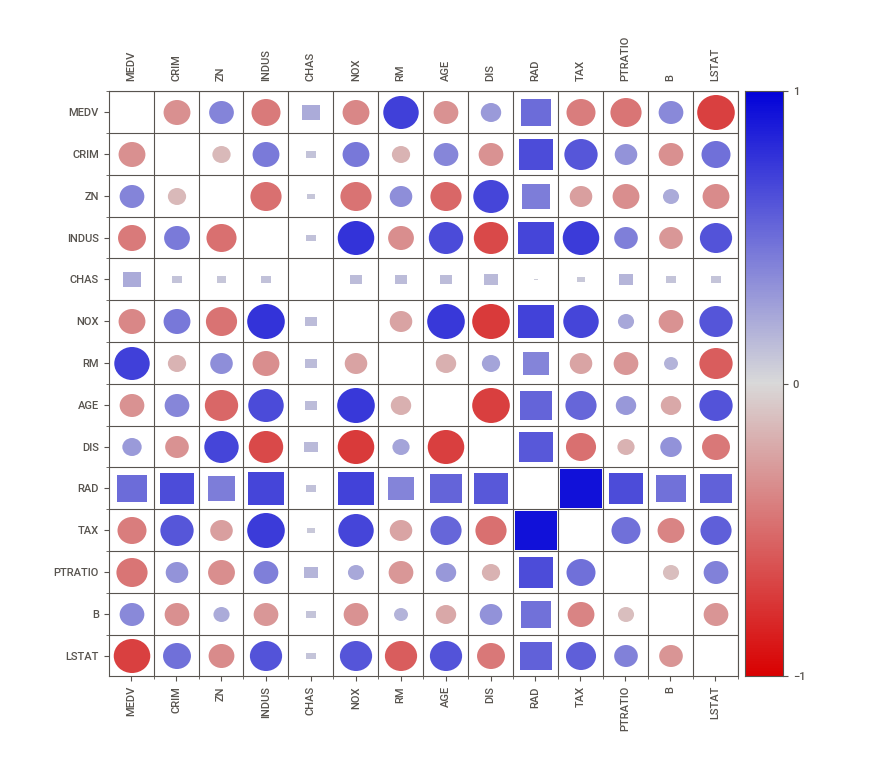
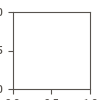

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
from IPython.display import HTML
reporte.show_html()
HTML('SWEETVIZ_REPORT.html')

<Axes: >

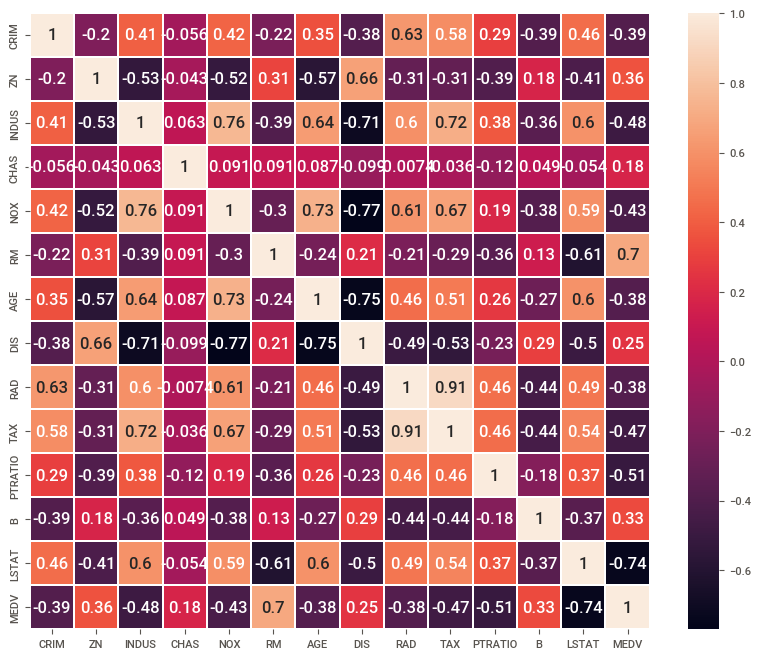

In [ ]:
plt.figure(figsize = (10,8))
c=datos.corr()
sns.heatmap(c, annot=True, linewidths=.1)

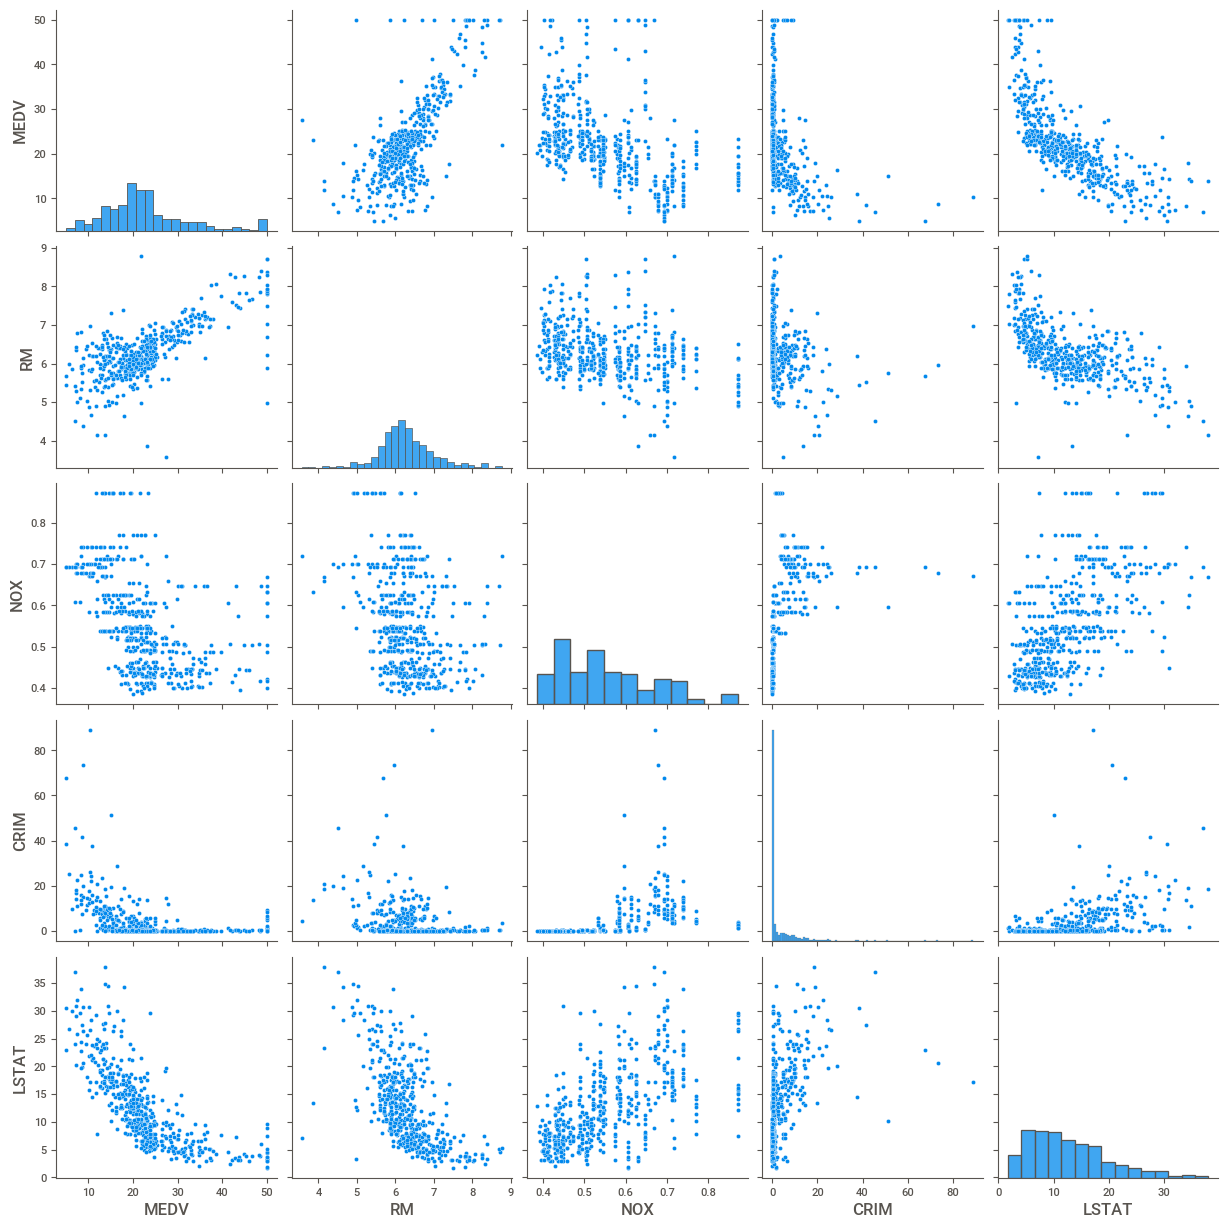

In [ ]:
sns.pairplot(datos[["MEDV", "RM", "NOX", "CRIM", "LSTAT"]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='MEDV', ylabel='LSTAT'>

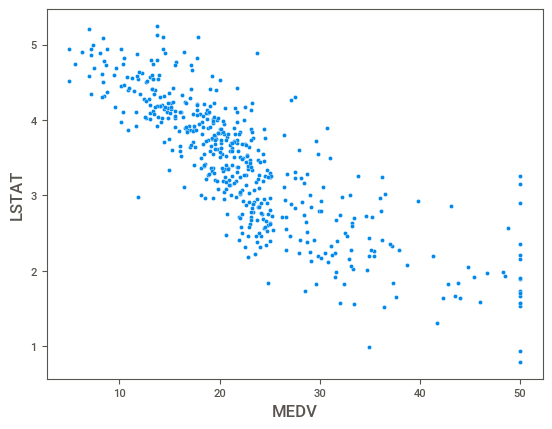

In [ ]:
sns.scatterplot(data=datos, x="MEDV", y=np.log2(datos["LSTAT"]))

### Ajuste del modelo

Se ajusta un modelo empleando como variable respuesta `MEDV` y como predictores todas las otras variables disponibles.

La clase `RandomForestRegressor` del módulo sklearn.ensemble permite entrenar modelos random forest para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

- `n_estimators=100`
- `criterion='mse'`
- `max_depth=None`
- `min_samples_split=2`
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features='auto'
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- bootstrap=True
- oob_score=False
- n_jobs=None
- random_state=None
- verbose=0
- warm_start=False
- ccp_alpha=0.0
- max_samples=None

De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

- `n_estimators`: número de árboles incluidos en el modelo.

- `max_depth`: profundidad máxima que pueden alcanzar los árboles.

- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `max_leaf_nodes`: número máximo de nodos terminales que pueden tener los árboles.

- `max_features`: número de predictores considerados a en cada división. Puede ser:

    + Un valor entero
    + Una fracción del total de predictores.
    + “auto”, utiliza todos los predictores.
    + “sqrt”, raiz cuadrada del número total de predictores.
    + “log2”, log2 del número total de predictores.
    + None, utiliza todos los predictores.
    + oob_score: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

- `n_jobs`: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

- `random_state: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.


Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

### División de los datos en train y test

In [ ]:
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_train.shape
#X_test.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(379, 13)

In [ ]:
y_train.shape

(379,)

### Creación del modelo

In [ ]:
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 100,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )



### Entrenamiento del modelo

In [ ]:
# ==============================================================================
modelo.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehI

RandomForestRegressor(criterion='mse', max_features='auto', n_jobs=-1,
                      random_state=123)

### Predicción y evaluación del modelo


Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.9447321616013


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
predicciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([31.841, 27.16 , 47.681, 20.428, 31.137, 43.827, 23.458,  8.886,
       18.37 , 30.485, 22.803, 19.869, 14.591, 24.721, 18.976, 21.017,
       20.485, 44.461, 19.255, 15.059, 15.513, 40.974, 33.282, 46.131,
       41.369, 22.446, 15.871, 20.516, 20.435, 21.552, 25.943, 32.537,
       15.862, 21.059, 23.302, 32.642, 24.492, 15.299, 15.403, 46.199,
       31.222, 19.013, 36.737, 48.456, 18.029, 22.221, 19.97 , 22.875,
       16.887, 33.434, 30.737, 27.738, 19.852, 10.241, 21.672, 15.023,
       13.552,  8.739, 34.335, 10.817, 18.931, 18.479, 17.422, 19.998,
       21.32 , 23.263, 23.228, 21.503, 22.956, 30.124, 20.128, 24.035,
       17.334, 26.065, 15.659, 17.769, 11.897, 19.462, 29.555, 12.166,
       32.143, 10.451, 24.123, 21.052, 19.135, 22.641, 15.492, 20.488,
       20.859, 29.218, 12.661, 34.541, 19.21 , 24.671, 33.261, 29.766,
       15.431, 29.68 , 24.78 , 33.619, 20.931, 14.594, 48.866, 13.694,
       20.003, 27.55 , 20.091, 13.483, 20.241, 26.553, 21.626, 20.327,
      

In [ ]:
a=y_test.reset_index()

In [ ]:
a.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['index', 'MEDV'], dtype='object')

In [ ]:
y_test.shape

(127,)

Text(0.5, 0, ' Observaciones')

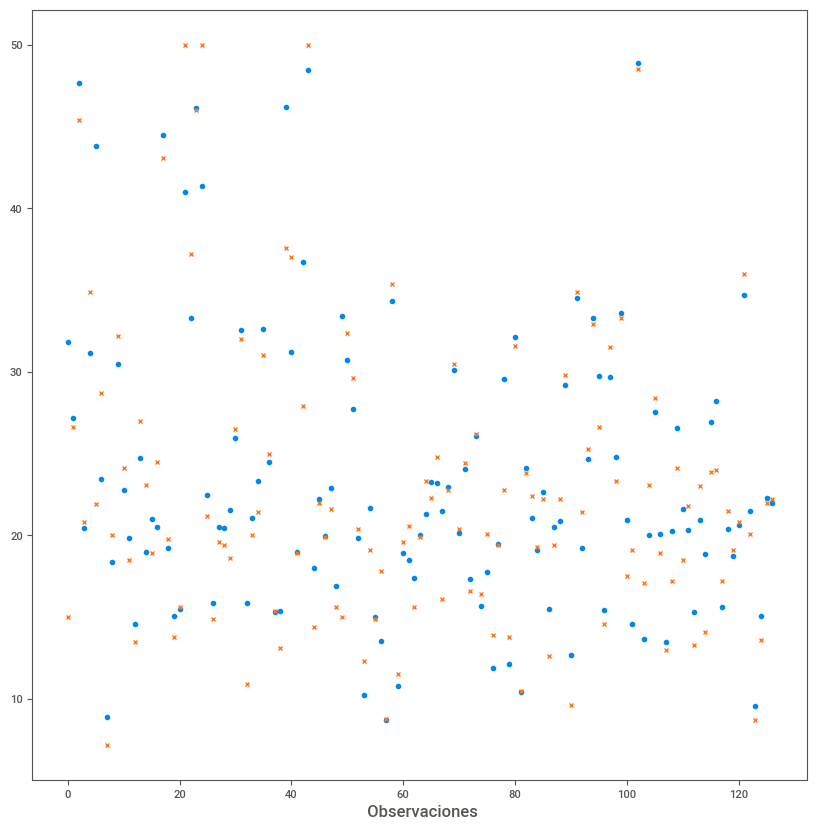

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(predicciones, "o")
plt.plot(a["MEDV"], "x")
plt.xlabel(" Observaciones")

<Axes: xlabel='MEDV'>

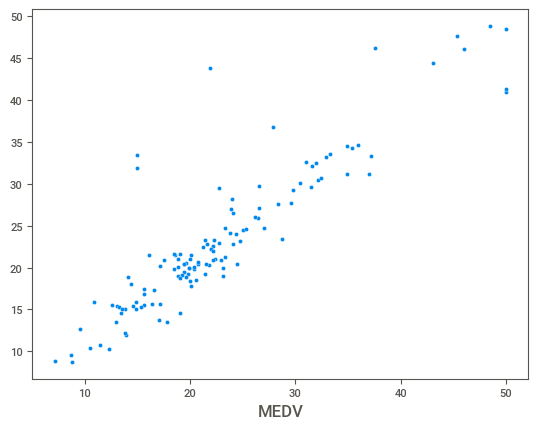

In [ ]:
sns.scatterplot(x=a["MEDV"], y=predicciones )

## Optimización de hiperparámetros


- El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. 

- Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

-Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. 

En la implementación de `RandomForestRegressor`, la métrica devuelta como `oob_score` es el  R2 , si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

## Grid search


Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

### Grid Search basado en out-of-bag error

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100,105,110],
                 'max_features': np.arange(5,12,2),
                 'max_depth'   : [None, 3,7,9, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 105} ✓
Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 110} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 105} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 110} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 105} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 110} ✓
Modelo: {'max_depth': None, 'max_features': 11, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 11, 'n_estimators': 105} ✓
Modelo: {'max_depth': None, 'max_features': 11, 'n_estimators': 110} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 105} ✓
Modelo: {'max_depth': 3

,oob_r2,max_depth,max_features,n_estimators
50,0.880367,20.0,5.0,110.0
2,0.880336,NaN,5.0,110.0
49,0.877099,20.0,5.0,105.0
1,0.877048,NaN,5.0,105.0


### Grid Search basado en validación cruzada

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [20, 30, 50,100, 120,150],
              'max_features': [5, 6, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
62,10,7,50,-3.309805,0.748836,-1.373985,0.089995
5,None,5,150,-3.322814,0.694243,-1.262209,0.070334
77,20,5,150,-3.323318,0.696368,-1.262743,0.070427
7,None,6,30,-3.338375,0.702898,-1.324335,0.077441


In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 7, 'n_estimators': 50} : -3.3098046458664894 neg_root_mean_squared_error


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.4779391747817003


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 4.35 a 3.74. Las predicciones del modelo final se alejan en promedio 3.74 unidades (3740 dólares) del valor real.

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
mape = mean_absolute_percentage_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (mape) de test es: {mape}")

El error (mape) de test es: 0.10440023350740647


### Importancia de predictores


Importancia por pureza de nodos

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "MEDV").columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
12,LSTAT,0.380999
5,RM,0.339311
10,PTRATIO,0.060188
4,NOX,0.052435
0,CRIM,0.049063
7,DIS,0.049000
9,TAX,0.016865
6,AGE,0.015666
2,INDUS,0.014538
11,B,0.014041


In [ ]:
!pip install shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/shap-0.41.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/loca

In [ ]:
import shap

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

In [ ]:
explainer = shap.Explainer(modelo_final)
shap_values = explainer(X_test)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


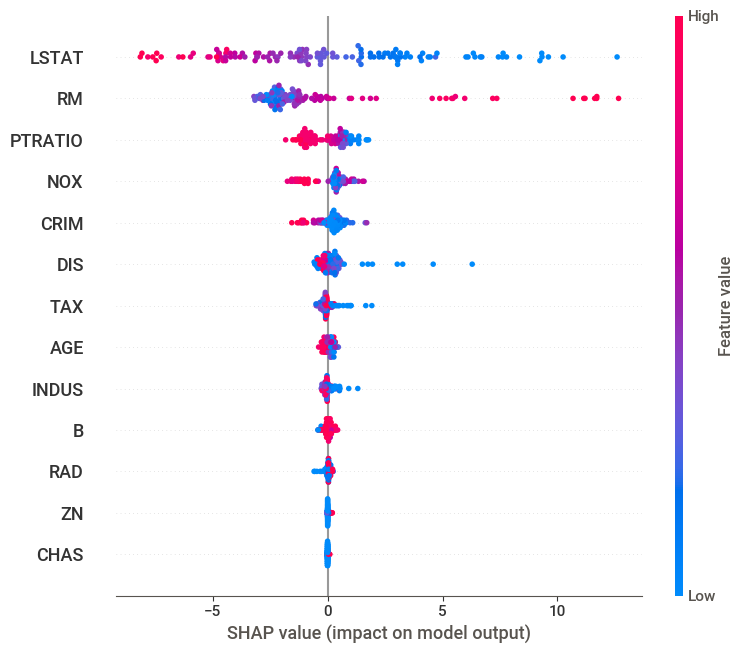

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=datos.columns)


In [ ]:
!pip install pycaret

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requ

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/ansi2html-1.8.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/category_encoders-2.6.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/dash-2.9.3.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/dash_core_components-2.0.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/dash_html_components-2.0.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/dash_table-5.0.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/Deprecated-1.

In [ ]:
datos.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [ ]:
from pycaret.regression import setup, compare_models, create_model, tune_model,   plot_model, save_model,evaluate_model

setup1 = setup(data = datos,  target = 'MEDV',  remove_outliers = True)

,Description,Value
0,Session id,5549
1,Target,MEDV
2,Target type,Regression
3,Original data shape,"(506, 14)"
4,Transformed data shape,"(488, 14)"
5,Transformed train set shape,"(336, 14)"
6,Transformed test set shape,"(152, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.3353,15.2398,3.6594,0.8287,0.1539,0.1140,0.3360
rf,Random Forest Regressor,2.4185,15.6809,3.6817,0.8242,0.1622,0.1215,0.4050
gbr,Gradient Boosting Regressor,2.3438,16.0131,3.6837,0.8216,0.1600,0.1180,0.3150
xgboost,Extreme Gradient Boosting,2.4572,16.6642,3.7755,0.8145,0.1638,0.1215,0.1820
lightgbm,Light Gradient Boosting Machine,2.6186,17.4169,3.9050,0.7920,0.1691,0.1307,0.0970
ada,AdaBoost Regressor,2.8554,20.5778,4.1987,0.7704,0.1888,0.1474,0.3570
dt,Decision Tree Regressor,3.2102,26.9805,4.9074,0.7007,0.2097,0.1635,0.0890
ridge,Ridge Regression,3.5793,29.2192,5.1612,0.6725,0.2926,0.1792,0.0630
lr,Linear Regression,3.6138,29.3186,5.1911,0.6698,0.2821,0.1799,0.5600
br,Bayesian Ridge,3.6464,29.9485,5.2401,0.6625,0.2973,0.1821,0.0650


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

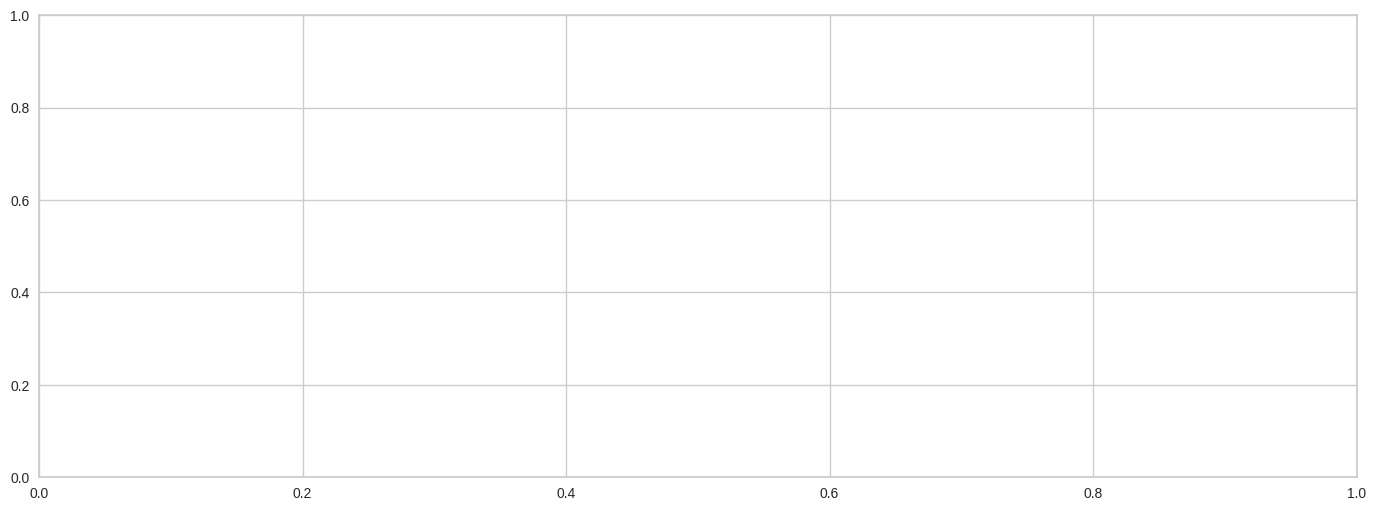

In [ ]:
evaluate_model(best_model)

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
rf_model = create_model('rf')
tuned_rf = tune_model(
    rf_model,
    optimize = 'MAE',
    #search_library = 'scikit-optimize',
     n_iter = 50
    )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2616,11.0703,3.3272,0.7952,0.1383,0.1065
1,2.0346,20.8708,4.5685,0.7582,0.1584,0.0960
2,2.5305,21.4495,4.6314,0.8494,0.1758,0.1123
3,2.3728,9.4282,3.0705,0.8283,0.1719,0.1454
4,2.0377,12.7455,3.5701,0.7926,0.1198,0.0850
5,1.8313,7.8373,2.7995,0.8880,0.1081,0.0809
6,3.2846,26.3694,5.1351,0.7511,0.2032,0.1569
7,1.4671,3.2076,1.7910,0.9569,0.0838,0.0689
8,2.2972,8.7596,2.9597,0.8833,0.1838,0.1515


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3891,11.8966,3.4491,0.7799,0.1305,0.1070
1,2.0594,19.5573,4.4224,0.7734,0.1431,0.0902
2,3.4031,27.9923,5.2908,0.8035,0.2036,0.1539
3,2.0419,6.3575,2.5214,0.8842,0.1541,0.1312
4,1.7707,9.5114,3.0841,0.8453,0.1051,0.0741
5,2.0148,8.1531,2.8554,0.8835,0.1167,0.0925
6,2.5369,12.3210,3.5101,0.8837,0.1335,0.1122
7,1.5013,3.6683,1.9153,0.9508,0.0950,0.0743
8,2.3667,9.6627,3.1085,0.8712,0.1811,0.1538


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
